# **The MUMDMC2025 Dataset_P3_DT&KNN-19062025.ipynb**


# **General**


In [1]:
# Install the autotime extension
#!pip install autotime
!pip install ipython-autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.5 MB/s eta 0:00:00


In [2]:
# Load the autotime extension
%load_ext autotime

time: 312 µs (started: 2025-06-19 14:36:57 +00:00)


In [4]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 7.45 s (started: 2025-06-19 14:40:36 +00:00)


# **Correct model for The Igneous and Metamorphic dataset**

🚀 Starting MUMDMC2025 Rock Classification Pipeline
🔗 Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully!
📥 Setting up dataset...
📁 Found dataset at: /content/drive/MyDrive/Colab Notebooks/MSc Datasets/Datasets/images/MUMDMC2025_DataSet_2500_500/Cropped
📊 Setting up dataset directory structure...
✅ Dataset setup completed!
🖼️ Loading images and extracting labels...
📊 Found 5 classes: ['Biotite', 'Hornblende', 'Plagioclase', 'Potassium Feldspar', 'Quartz']
  Loading 500 images from Biotite...
  Loading 500 images from Hornblende...
  Loading 500 images from Plagioclase...
  Loading 500 images from Potassium Feldspar...
  Loading 500 images from Quartz...
✅ Loaded 2500 images successfully!
📊 Dataset composition:
  Biotite: 500 images
  Hornblende: 500 images
  Plagioclase: 500 images
  Potassium Feldspar: 500 images
  Quartz: 500 images
📊 Creating clas

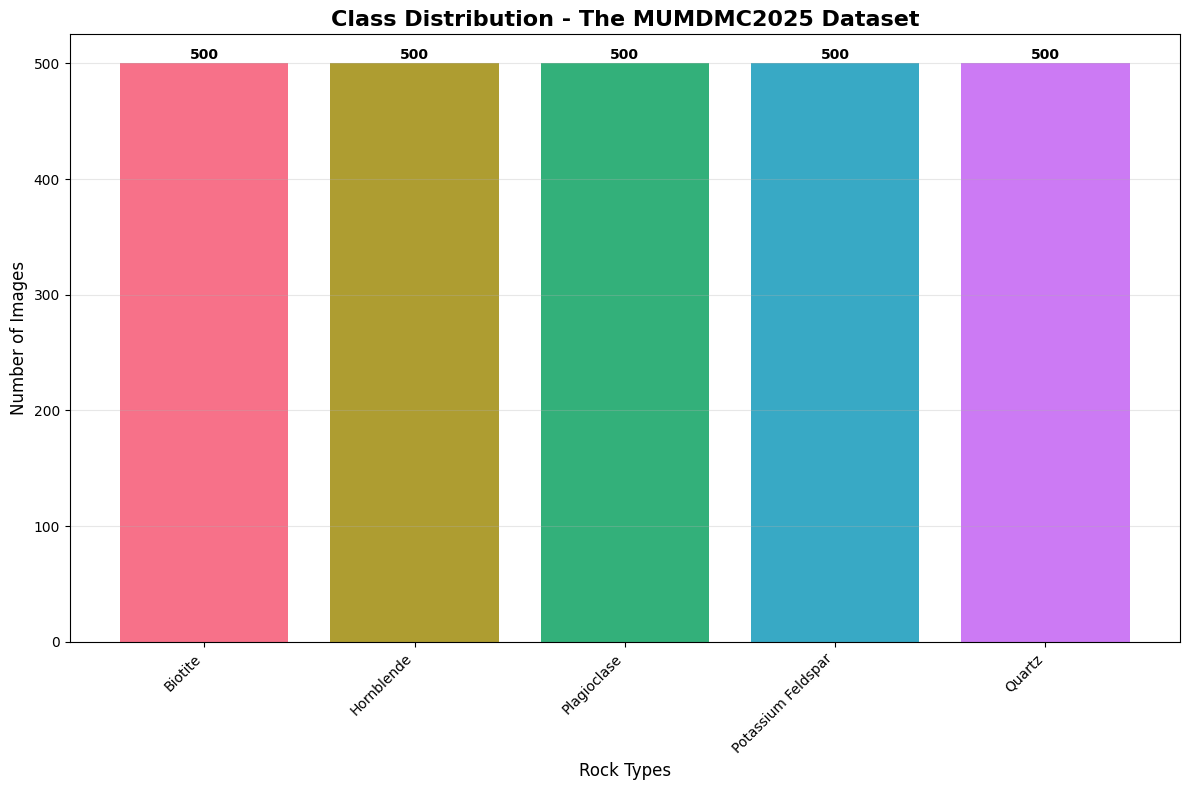

🔄 Preprocessing data...
  Analyzing original image dimensions...
  Most common original size: (547, 500)
  Using standard size instead: (224, 224)
  Converting original images to features...
  Processing 2500 images...
    Processed 500/2500 images...
    Processed 1000/2500 images...
    Processed 1500/2500 images...
    Processed 2000/2500 images...
    Processed 2500/2500 images...
  Original images shape: (2500, 150528)
  Converting resized images to features...
  Processing 2500 images...
    Processed 500/2500 images...
    Processed 1000/2500 images...
    Processed 1500/2500 images...
    Processed 2000/2500 images...
    Processed 2500/2500 images...
  Resized images shape: (2500, 67500)
  Labels encoded: 5 classes
✅ Data preprocessing completed!
🔀 Creating train-test split (80/20)...
Training set: 2000 samples
Test set: 500 samples
✅ Train-test split completed!
🤖 Training models...

📈 Training on Original images...
  Training DecisionTree...
    Training time: 238.46s
    Tes

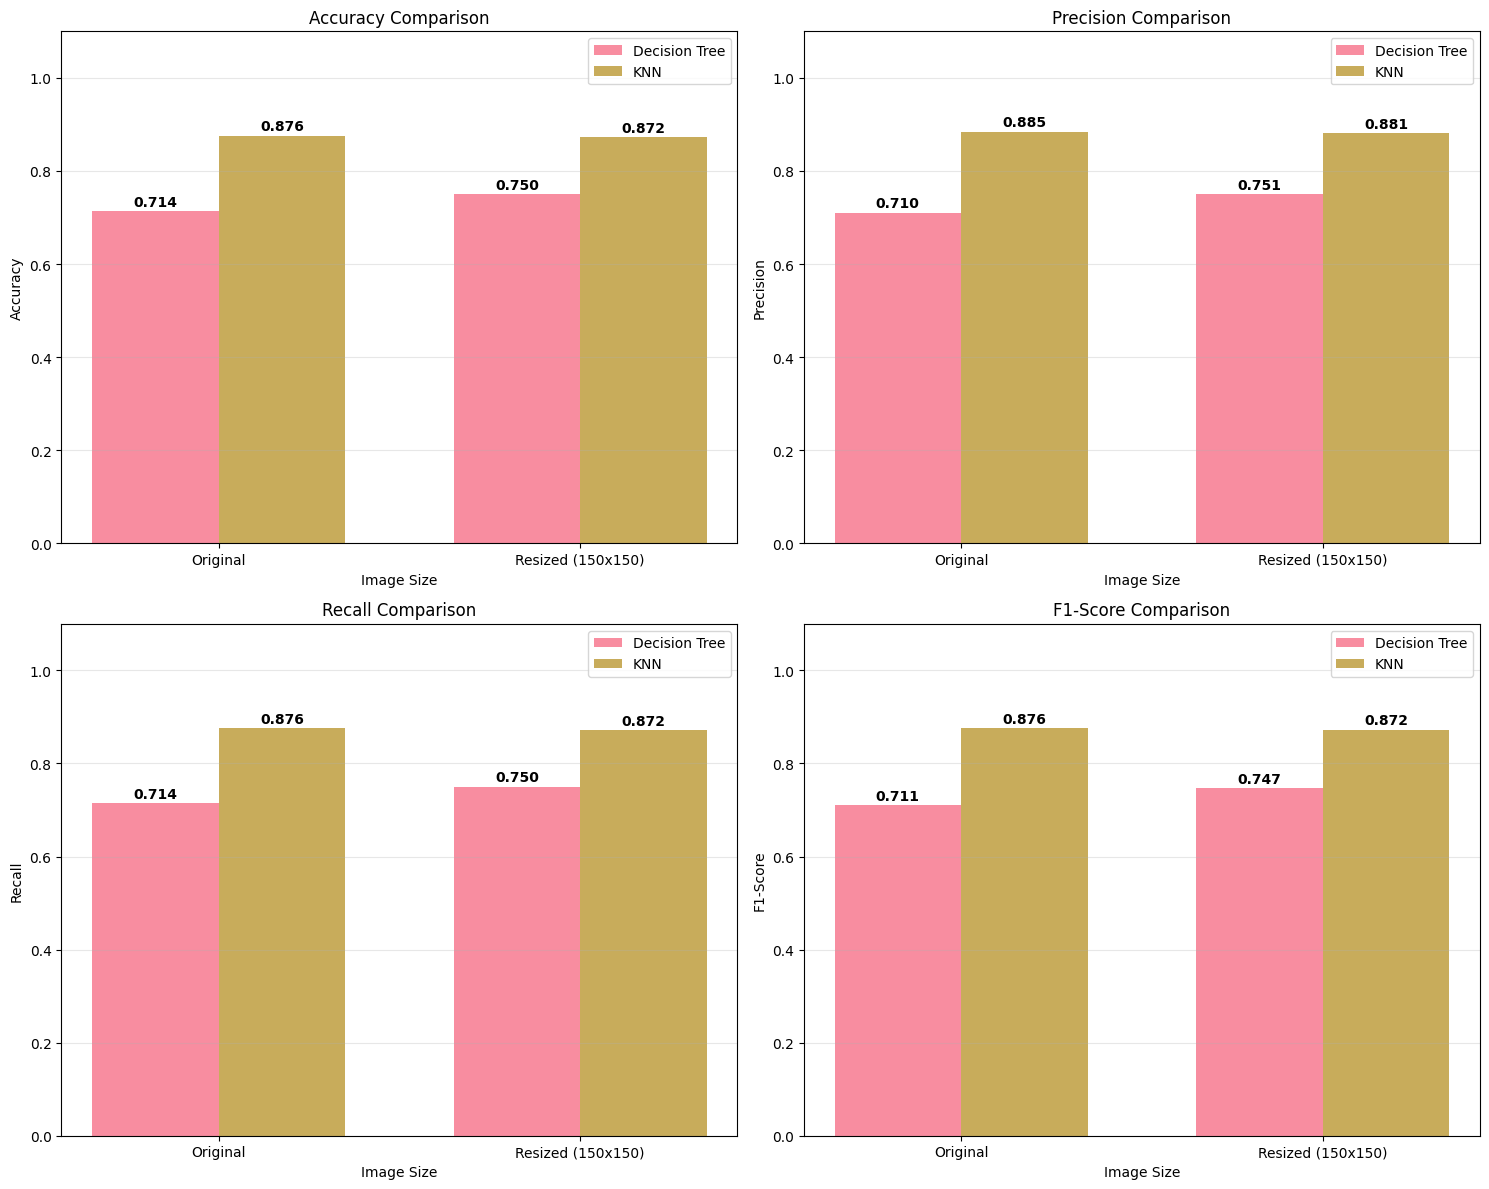

🔥 Creating confusion matrices...


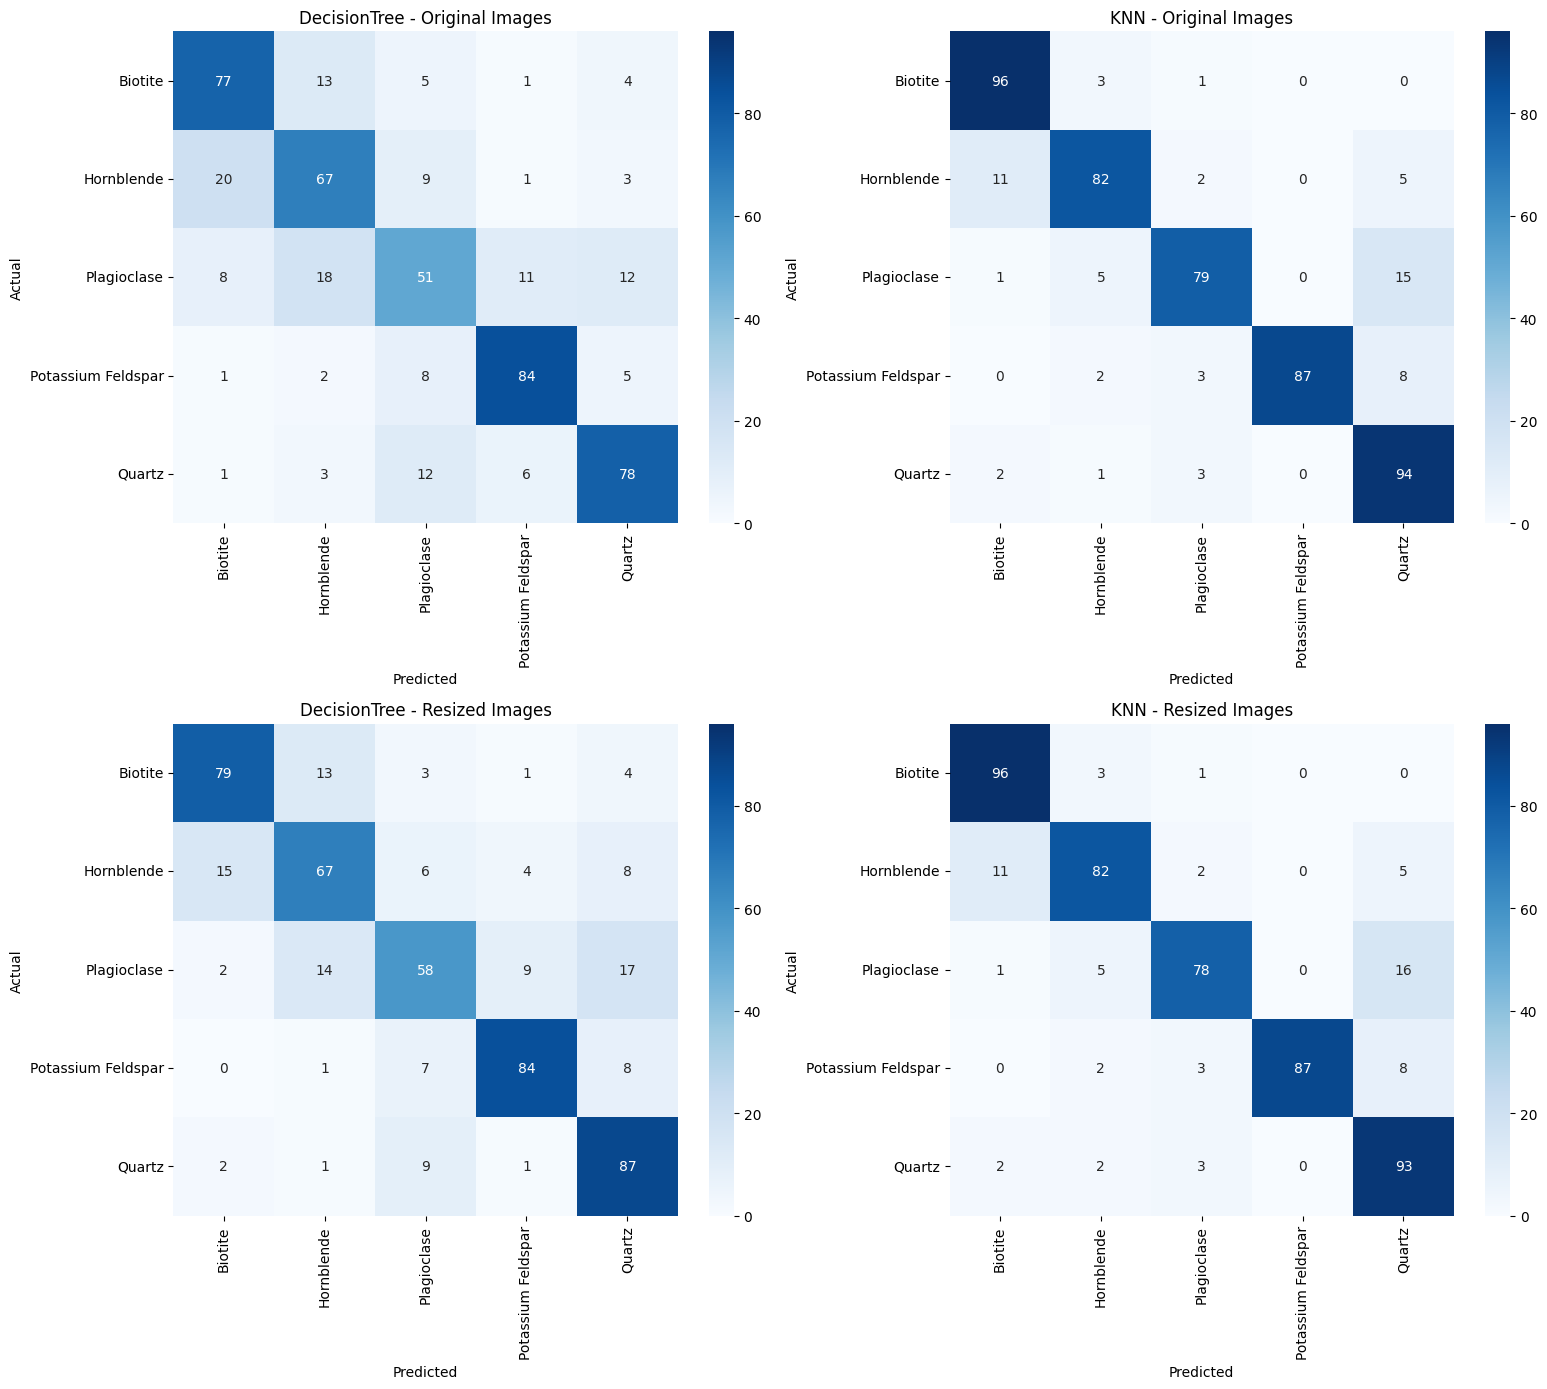

📈 Creating ROC-AUC curves...


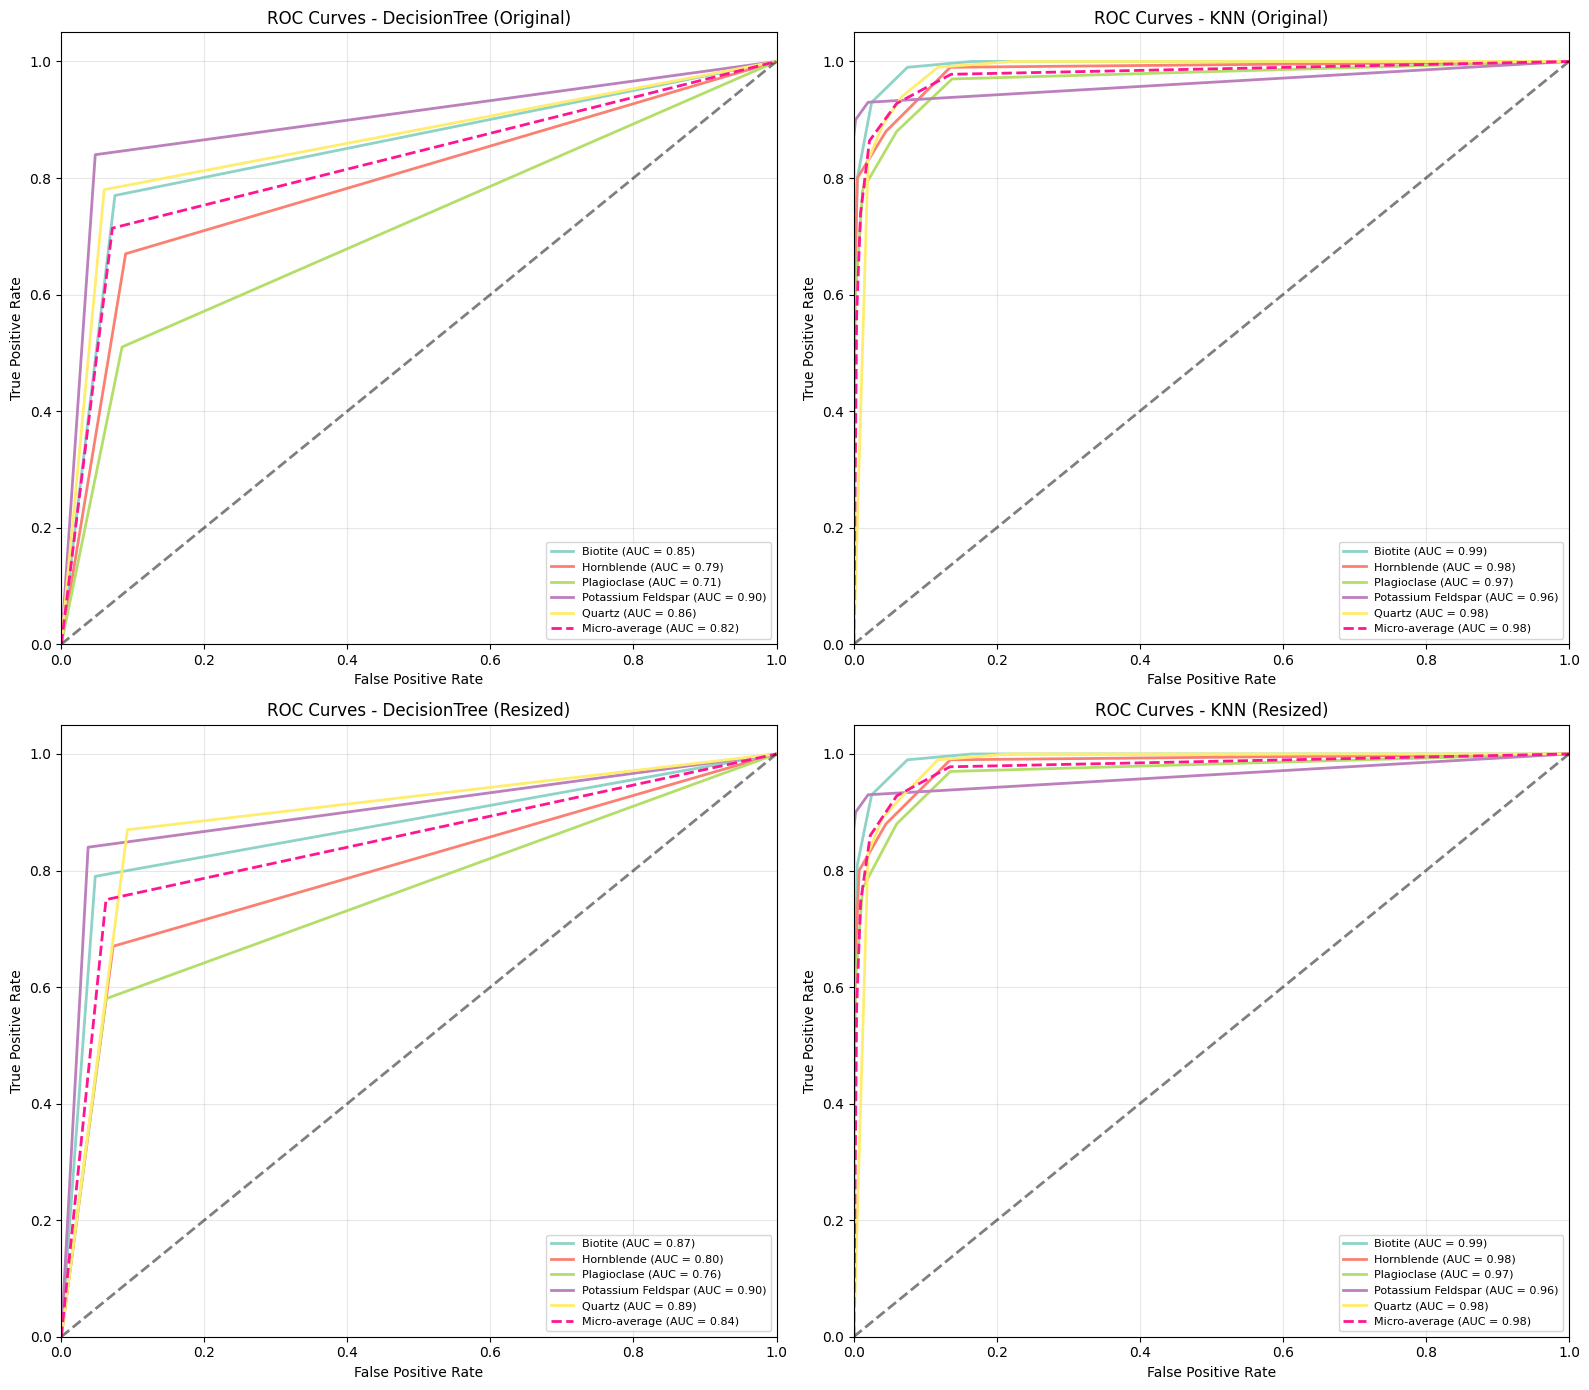

✅ ROC-AUC curves completed!
💾 Saving results to CSV files...
✅ Results saved to CSV files!
💾 Saving metadata to CSV...
✅ Metadata saved to CSV files!
🖼️ Creating sample images visualization...


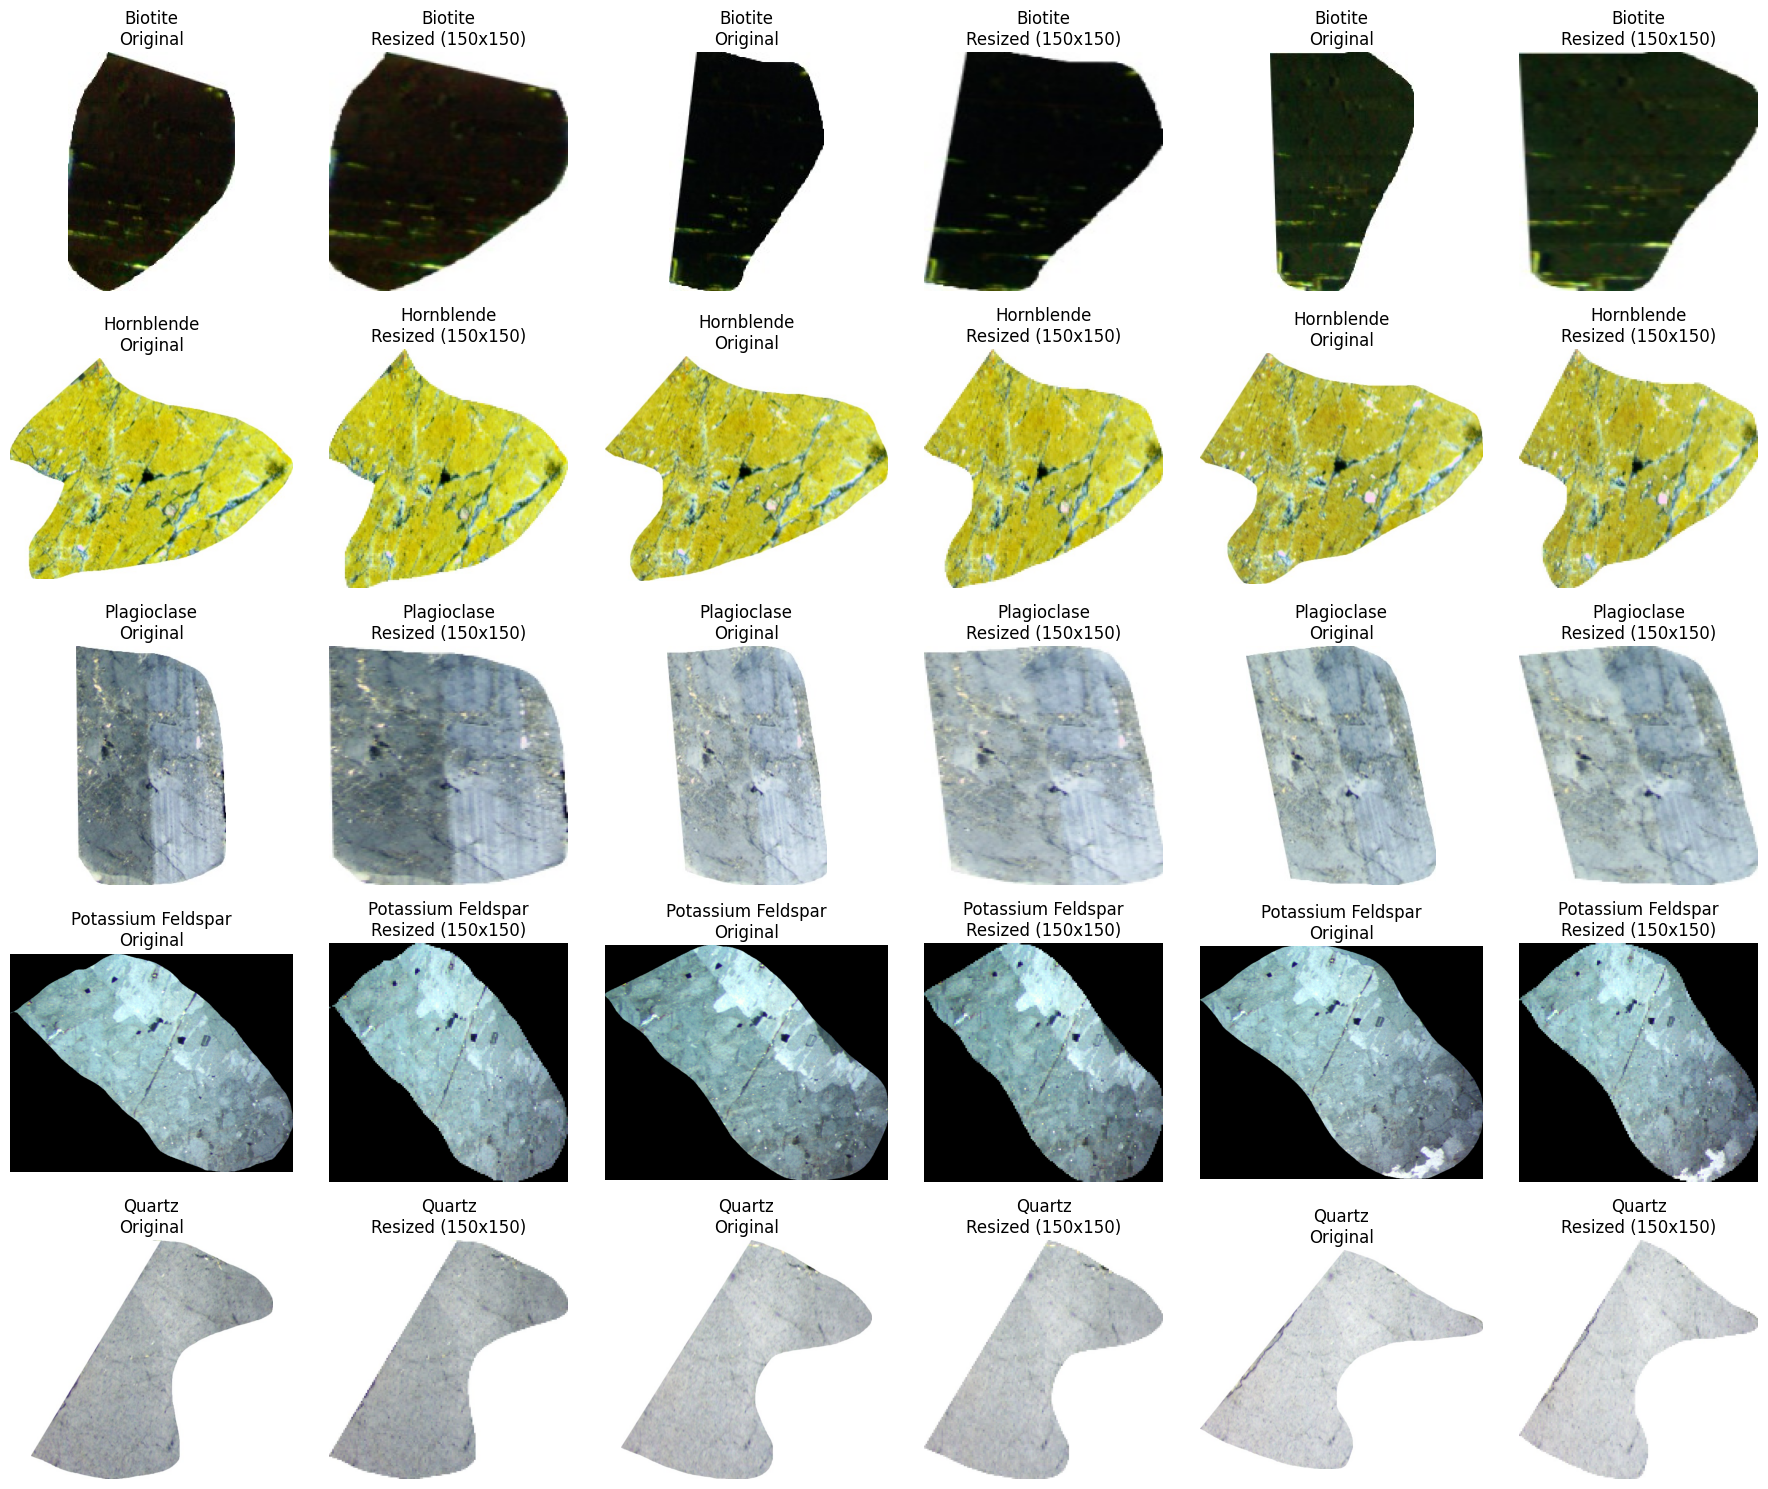


🎉 Pipeline completed successfully!
📁 All outputs saved in '/content/outputs/' directory

📊 FINAL SUMMARY
Generated Files:
• class_distribution.png - Class distribution bar plot
• performance_metrics.png - Model performance comparison
• confusion_matrices.png - Confusion matrices for all models
• roc_curves.png - ROC-AUC curves for all models
• sample_images.png - Sample images before/after resize
• class_distribution.csv - Class counts
• performance_metrics.csv - All performance metrics
• confusion_matrices.csv - Confusion matrix data
• dataset_metadata.csv - Complete image metadata
• dataset_summary.csv - Dataset summary statistics

✅ Ready for download and analysis!
time: 9min 32s (started: 2025-06-19 14:41:51 +00:00)


In [5]:
#!/usr/bin/env python3
"""
MUMDMC2025 Igneous Rock Classification Pipeline
A comprehensive machine learning pipeline for igneous rock type classification
"""

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_curve, auc,
                           classification_report, roc_auc_score)
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import cv2
import time
from collections import Counter
from google.colab import drive
import zipfile
import shutil
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

class RockClassificationPipeline:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.images_original = []
        self.images_resized = []
        self.labels = []
        self.class_names = []
        self.label_encoder = LabelEncoder()
        self.scaler = StandardScaler()
        self.results = {}
        self.metadata = []
        self.common_size = None  # Store the common size for original images

    def mount_drive(self):
        """Mount Google Drive"""
        print("🔗 Mounting Google Drive...")
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully!")

    def download_and_setup(self):
        """Download and setup the dataset"""
        print("📥 Setting up dataset...")

        # Create directories
        os.makedirs('/content/dataset', exist_ok=True)
        os.makedirs('/content/outputs', exist_ok=True)
        os.makedirs('/content/models', exist_ok=True)

        # Use the specific dataset path provided
        dataset_source = self.dataset_path

        if os.path.exists(dataset_source):
            print(f"📁 Found dataset at: {dataset_source}")
            print(f"📊 Setting up dataset directory structure...")
            # The dataset is already in the correct location, just point to it
            self.dataset_dir = dataset_source
        else:
            print(f"❌ Dataset not found at: {dataset_source}")
            print("Please ensure your dataset path is correct")
            return False

        print("✅ Dataset setup completed!")
        return True

    def load_images_and_labels(self):
        """Load images and extract labels"""
        print("🖼️ Loading images and extracting labels...")

        dataset_dir = self.dataset_dir

        if not os.path.exists(dataset_dir):
            print(f"❌ Dataset directory not found: {dataset_dir}")
            return

        # Get class folders
        class_folders = [f for f in os.listdir(dataset_dir)
                        if os.path.isdir(os.path.join(dataset_dir, f))]
        self.class_names = sorted(class_folders)

        print(f"📊 Found {len(self.class_names)} classes: {self.class_names}")

        for class_name in self.class_names:
            class_path = os.path.join(dataset_dir, class_name)
            image_files = [f for f in os.listdir(class_path)
                          if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff'))]

            print(f"  Loading {len(image_files)} images from {class_name}...")

            for img_file in image_files:
                img_path = os.path.join(class_path, img_file)

                try:
                    # Load original image
                    img_original = cv2.imread(img_path)
                    if img_original is not None:
                        img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

                        # Store original image
                        self.images_original.append(img_original)

                        # Create resized version (150x150)
                        img_resized = cv2.resize(img_original, (150, 150))
                        self.images_resized.append(img_resized)

                        # Store label
                        self.labels.append(class_name)

                        # Store metadata
                        img_shape = img_original.shape
                        file_size = os.path.getsize(img_path)
                        self.metadata.append({
                            'filename': img_file,
                            'class': class_name,
                            'original_height': img_shape[0],
                            'original_width': img_shape[1],
                            'channels': img_shape[2],
                            'file_size_bytes': file_size,
                            'file_path': img_path
                        })

                except Exception as e:
                    print(f"⚠️ Error loading {img_path}: {e}")
                    continue

        print(f"✅ Loaded {len(self.images_original)} images successfully!")
        print(f"📊 Dataset composition:")
        class_counts = Counter(self.labels)
        for class_name, count in sorted(class_counts.items()):
            print(f"  {class_name}: {count} images")

    def plot_class_distribution(self):
        """Create bar plot for class distribution"""
        print("📊 Creating class distribution plot...")

        class_counts = Counter(self.labels)
        classes = list(class_counts.keys())
        counts = list(class_counts.values())

        plt.figure(figsize=(12, 8))
        bars = plt.bar(classes, counts, color=sns.color_palette("husl", len(classes)))

        # Add count labels on bars
        for bar, count in zip(bars, counts):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    str(count), ha='center', va='bottom', fontweight='bold')

        plt.title('Class Distribution - The MUMDMC2025 Dataset', fontsize=16, fontweight='bold')
        plt.xlabel('Rock Types', fontsize=12)
        plt.ylabel('Number of Images', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()

        # Save plot
        plt.savefig('/content/outputs/class_distribution.svg', bbox_inches='tight')
        plt.savefig('/content/outputs/class_distribution.png', dpi=900, bbox_inches='tight')
        plt.show()

        return class_counts

    def preprocess_data(self):
        """Normalize and encode labels"""
        print("🔄 Preprocessing data...")

        # Convert images to feature vectors (flatten)
        def images_to_features(images, target_size=None):
            features = []
            print(f"  Processing {len(images)} images...")

            for i, img in enumerate(images):
                try:
                    # Resize to standard size if needed for original images
                    if target_size is not None and img.shape[:2] != target_size:
                        img = cv2.resize(img, target_size)

                    # Flatten and normalize
                    flattened = img.flatten().astype(np.float32) / 255.0
                    features.append(flattened)

                    if (i + 1) % 500 == 0:
                        print(f"    Processed {i + 1}/{len(images)} images...")

                except Exception as e:
                    print(f"  ⚠️ Error processing image {i}: {e}")
                    continue

            return np.array(features)

        # Find common size for original images (use most common dimensions)
        print("  Analyzing original image dimensions...")
        dimensions = {}
        for img in self.images_original:
            dim = (img.shape[1], img.shape[0])  # (width, height)
            dimensions[dim] = dimensions.get(dim, 0) + 1

        # Use the most common dimension, or a reasonable default
        if dimensions:
            common_size = max(dimensions.items(), key=lambda x: x[1])[0]
            print(f"  Most common original size: {common_size}")

            # If the most common size is too large, use a reasonable size
            if common_size[0] * common_size[1] > 300 * 300:
                common_size = (224, 224)  # Standard size for image processing
                print(f"  Using standard size instead: {common_size}")
        else:
            common_size = (224, 224)
            print(f"  Using default size: {common_size}")

        # Store common size for later use
        self.common_size = common_size

        # Process original images (resize to common size)
        print("  Converting original images to features...")
        self.X_original = images_to_features(self.images_original, target_size=common_size)
        print(f"  Original images shape: {self.X_original.shape}")

        # Process resized images (already 150x150)
        print("  Converting resized images to features...")
        self.X_resized = images_to_features(self.images_resized)
        print(f"  Resized images shape: {self.X_resized.shape}")

        # Encode labels
        self.y_encoded = self.label_encoder.fit_transform(self.labels)
        print(f"  Labels encoded: {len(np.unique(self.y_encoded))} classes")

        # Verify data consistency
        assert len(self.X_original) == len(self.X_resized) == len(self.y_encoded), \
            "Mismatch in number of samples between features and labels"

        print("✅ Data preprocessing completed!")

    def create_train_test_split(self):
        """Create 80/20 train-test split"""
        print("🔀 Creating train-test split (80/20)...")

        # Split original images
        (self.X_train_orig, self.X_test_orig,
         self.y_train, self.y_test) = train_test_split(
            self.X_original, self.y_encoded,
            test_size=0.2, random_state=42, stratify=self.y_encoded
        )

        # Split resized images (same indices)
        (self.X_train_resized, self.X_test_resized,
         _, _) = train_test_split(
            self.X_resized, self.y_encoded,
            test_size=0.2, random_state=42, stratify=self.y_encoded
        )

        print(f"Training set: {self.X_train_orig.shape[0]} samples")
        print(f"Test set: {self.X_test_orig.shape[0]} samples")
        print("✅ Train-test split completed!")

    def train_models(self):
        """Train DT and KNN models on both original and resized images"""
        print("🤖 Training models...")

        # Create model instances for each dataset
        self.trained_models = {
            'Original': {
                'DecisionTree': DecisionTreeClassifier(random_state=42),
                'KNN': KNeighborsClassifier()
            },
            'Resized': {
                'DecisionTree': DecisionTreeClassifier(random_state=42),
                'KNN': KNeighborsClassifier()
            }
        }

        self.training_times = {}

        for dataset_name in ['Original', 'Resized']:
            print(f"\n📈 Training on {dataset_name} images...")
            self.training_times[dataset_name] = {}

            # Get the correct training data
            if dataset_name == 'Original':
                X_train = self.X_train_orig
                X_test = self.X_test_orig
            else:  # Resized
                X_train = self.X_train_resized
                X_test = self.X_test_resized

            for model_name in self.trained_models[dataset_name]:
                model = self.trained_models[dataset_name][model_name]
                print(f"  Training {model_name}...")

                # Train model and measure time
                start_time = time.time()
                model.fit(X_train, self.y_train)
                training_time = time.time() - start_time

                # Test model and measure time
                start_time = time.time()
                y_pred = model.predict(X_test)
                testing_time = time.time() - start_time

                # Store results
                self.trained_models[dataset_name][model_name] = {
                    'model': model,
                    'predictions': y_pred,
                    'training_time': training_time,
                    'testing_time': testing_time,
                    'X_train': X_train,  # Store exact features used
                    'X_test': X_test      # Store exact features used
                }

                print(f"    Training time: {training_time:.2f}s")
                print(f"    Testing time: {testing_time:.2f}s")

        print("✅ Model training completed!")

    def calculate_metrics(self):
        """Calculate performance metrics for all models"""
        print("📊 Calculating performance metrics...")

        self.metrics_results = {}

        for dataset_name in self.trained_models:
            self.metrics_results[dataset_name] = {}

            for model_name in self.trained_models[dataset_name]:
                model_info = self.trained_models[dataset_name][model_name]
                y_pred = model_info['predictions']

                # Calculate metrics
                accuracy = accuracy_score(self.y_test, y_pred)
                precision = precision_score(self.y_test, y_pred, average='weighted')
                recall = recall_score(self.y_test, y_pred, average='weighted')
                f1 = f1_score(self.y_test, y_pred, average='weighted')

                self.metrics_results[dataset_name][model_name] = {
                    'accuracy': accuracy,
                    'precision': precision,
                    'recall': recall,
                    'f1_score': f1,
                    'training_time': model_info['training_time'],
                    'testing_time': model_info['testing_time']
                }

                print(f"{dataset_name} - {model_name}:")
                print(f"  Accuracy: {accuracy:.3f}")
                print(f"  Precision: {precision:.3f}")
                print(f"  Recall: {recall:.3f}")
                print(f"  F1-Score: {f1:.3f}")

        print("✅ Metrics calculation completed!")

    def plot_performance_metrics(self):
        """Create bar plot for performance metrics comparison"""
        print("📊 Creating performance metrics plot...")

        # Prepare data for plotting
        metrics = ['accuracy', 'precision', 'recall', 'f1_score']
        metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        axes = axes.ravel()

        for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
            ax = axes[i]

            # Extract data
            dt_orig = self.metrics_results['Original']['DecisionTree'][metric]
            dt_resized = self.metrics_results['Resized']['DecisionTree'][metric]
            knn_orig = self.metrics_results['Original']['KNN'][metric]
            knn_resized = self.metrics_results['Resized']['KNN'][metric]

            # Create bars
            x = np.arange(2)
            width = 0.35

            bars1 = ax.bar(x - width/2, [dt_orig, dt_resized], width,
                          label='Decision Tree', alpha=0.8)
            bars2 = ax.bar(x + width/2, [knn_orig, knn_resized], width,
                          label='KNN', alpha=0.8)

            # Add value labels on bars
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                           f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

            ax.set_xlabel('Image Size')
            ax.set_ylabel(metric_name)
            ax.set_title(f'{metric_name} Comparison')
            ax.set_xticks(x)
            ax.set_xticklabels(['Original', 'Resized (150x150)'])
            ax.legend()
            ax.set_ylim(0, 1.1)
            ax.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.savefig('/content/outputs/performance_metrics.svg', bbox_inches='tight')
        plt.savefig('/content/outputs/performance_metrics.png', dpi=900, bbox_inches='tight')
        plt.show()

    def plot_confusion_matrices(self):
        """Create confusion matrices for all models"""
        print("🔥 Creating confusion matrices...")

        fig, axes = plt.subplots(2, 2, figsize=(16, 14))

        plot_configs = [
            ('Original', 'DecisionTree', axes[0, 0]),
            ('Original', 'KNN', axes[0, 1]),
            ('Resized', 'DecisionTree', axes[1, 0]),
            ('Resized', 'KNN', axes[1, 1])
        ]

        # Find global min/max for consistent color scaling
        all_cms = []
        for dataset_name in self.trained_models:
            for model_name in self.trained_models[dataset_name]:
                y_pred = self.trained_models[dataset_name][model_name]['predictions']
                cm = confusion_matrix(self.y_test, y_pred)
                all_cms.append(cm)

        vmin = min(cm.min() for cm in all_cms)
        vmax = max(cm.max() for cm in all_cms)

        for dataset_name, model_name, ax in plot_configs:
            y_pred = self.trained_models[dataset_name][model_name]['predictions']
            cm = confusion_matrix(self.y_test, y_pred)

            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=self.class_names, yticklabels=self.class_names,
                       ax=ax, vmin=vmin, vmax=vmax)

            ax.set_title(f'{model_name} - {dataset_name} Images')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('Actual')

        plt.tight_layout()
        plt.savefig('/content/outputs/confusion_matrices.svg', bbox_inches='tight')
        plt.savefig('/content/outputs/confusion_matrices.png', dpi=900, bbox_inches='tight')
        plt.show()

    def plot_roc_curves(self):
        """Create ROC-AUC curves for all models"""
        print("📈 Creating ROC-AUC curves...")

        # Binarize labels for multiclass ROC
        y_test_bin = label_binarize(self.y_test, classes=range(len(self.class_names)))
        n_classes = len(self.class_names)

        fig, axes = plt.subplots(2, 2, figsize=(16, 14))

        plot_configs = [
            ('Original', 'DecisionTree', axes[0, 0]),
            ('Original', 'KNN', axes[0, 1]),
            ('Resized', 'DecisionTree', axes[1, 0]),
            ('Resized', 'KNN', axes[1, 1])
        ]

        for dataset_name, model_name, ax in plot_configs:
            model_info = self.trained_models[dataset_name][model_name]
            model = model_info['model']
            X_test_data = model_info['X_test']  # Use stored test features

            # Get prediction probabilities or decision scores
            try:
                if hasattr(model, "predict_proba"):
                    y_score = model.predict_proba(X_test_data)
                elif hasattr(model, "decision_function"):
                    y_score = model.decision_function(X_test_data)
                    # Convert decision function output to probabilities for multiclass
                    if y_score.ndim == 1:
                        # Binary case
                        y_score = np.column_stack([1 - y_score, y_score])
                    else:
                        # Multiclass case - normalize decision scores
                        from scipy.special import softmax
                        y_score = softmax(y_score, axis=1)
                else:
                    # If neither is available, skip this model
                    ax.text(0.5, 0.5, f'ROC not available for {model_name}\n(No probability estimation)',
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f'ROC Curves - {model_name} ({dataset_name})')
                    continue

                # Calculate ROC curve and AUC for each class
                fpr, tpr, roc_auc = {}, {}, {}

                if n_classes == 2:
                    # Binary classification
                    fpr[0], tpr[0], _ = roc_curve(y_test_bin.ravel(), y_score[:, 1])
                    roc_auc[0] = auc(fpr[0], tpr[0])

                    ax.plot(fpr[0], tpr[0], lw=2,
                           label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
                else:
                    # Multiclass classification
                    colors = plt.cm.Set3(np.linspace(0, 1, n_classes))
                    for i in range(n_classes):
                        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
                        roc_auc[i] = auc(fpr[i], tpr[i])

                        ax.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                               label=f'{self.class_names[i]} (AUC = {roc_auc[i]:.2f})')

                    # Calculate micro-average ROC curve and AUC
                    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(),
                                                            y_score.ravel())
                    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

                    ax.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle='--', lw=2,
                           label=f'Micro-average (AUC = {roc_auc["micro"]:.2f})')

                # Plot diagonal line
                ax.plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.5)
                ax.set_xlim([0.0, 1.0])
                ax.set_ylim([0.0, 1.05])
                ax.set_xlabel('False Positive Rate')
                ax.set_ylabel('True Positive Rate')
                ax.set_title(f'ROC Curves - {model_name} ({dataset_name})')
                ax.legend(loc="lower right", fontsize=8)
                ax.grid(alpha=0.3)

            except Exception as e:
                print(f"⚠️ Error creating ROC curve for {model_name} ({dataset_name}): {e}")
                ax.text(0.5, 0.5, f'Error creating ROC curve\nfor {model_name}',
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'ROC Curves - {model_name} ({dataset_name})')

        plt.tight_layout()
        plt.savefig('/content/outputs/roc_curves.svg', bbox_inches='tight')
        plt.savefig('/content/outputs/roc_curves.png', dpi=900, bbox_inches='tight')
        plt.show()

        print("✅ ROC-AUC curves completed!")

    def save_results_csv(self):
        """Save all results to CSV files"""
        print("💾 Saving results to CSV files...")

        # 1. Class distribution CSV
        class_counts = Counter(self.labels)
        class_df = pd.DataFrame(list(class_counts.items()),
                               columns=['Class', 'Count'])
        class_df.to_csv('/content/outputs/class_distribution.csv', index=False)

        # 2. Performance metrics CSV
        metrics_data = []
        for dataset_name in self.metrics_results:
            for model_name in self.metrics_results[dataset_name]:
                metrics = self.metrics_results[dataset_name][model_name]
                metrics_data.append({
                    'Dataset': dataset_name,
                    'Model': model_name,
                    'Accuracy': metrics['accuracy'],
                    'Precision': metrics['precision'],
                    'Recall': metrics['recall'],
                    'F1_Score': metrics['f1_score'],
                    'Training_Time': metrics['training_time'],
                    'Testing_Time': metrics['testing_time']
                })

        metrics_df = pd.DataFrame(metrics_data)
        metrics_df.to_csv('/content/outputs/performance_metrics.csv', index=False)

        # 3. Confusion matrices CSV
        cm_data = []
        for dataset_name in self.trained_models:
            for model_name in self.trained_models[dataset_name]:
                y_pred = self.trained_models[dataset_name][model_name]['predictions']
                cm = confusion_matrix(self.y_test, y_pred)

                # Flatten confusion matrix
                for i, true_class in enumerate(self.class_names):
                    for j, pred_class in enumerate(self.class_names):
                        cm_data.append({
                            'Dataset': dataset_name,
                            'Model': model_name,
                            'True_Class': true_class,
                            'Predicted_Class': pred_class,
                            'Count': cm[i, j]
                        })

        cm_df = pd.DataFrame(cm_data)
        cm_df.to_csv('/content/outputs/confusion_matrices.csv', index=False)

        print("✅ Results saved to CSV files!")

    def save_metadata_csv(self):
        """Save dataset metadata to CSV"""
        print("💾 Saving metadata to CSV...")

        metadata_df = pd.DataFrame(self.metadata)

        # Add additional statistics
        metadata_df['aspect_ratio'] = (metadata_df['original_width'] /
                                     metadata_df['original_height'])

        # Summary statistics
        summary_stats = {
            'total_images': len(metadata_df),
            'total_classes': len(metadata_df['class'].unique()),
            'avg_width': metadata_df['original_width'].mean(),
            'avg_height': metadata_df['original_height'].mean(),
            'avg_file_size': metadata_df['file_size_bytes'].mean(),
            'total_dataset_size': metadata_df['file_size_bytes'].sum()
        }

        # Save detailed metadata
        metadata_df.to_csv('/content/outputs/dataset_metadata.csv', index=False)

        # Save summary statistics
        summary_df = pd.DataFrame([summary_stats])
        summary_df.to_csv('/content/outputs/dataset_summary.csv', index=False)

        print("✅ Metadata saved to CSV files!")

    def show_sample_images(self):
        """Show 3 samples from each class before and after resize"""
        print("🖼️ Creating sample images visualization...")

        # Group images by class
        class_samples = {class_name: [] for class_name in self.class_names}

        for i, label in enumerate(self.labels):
            if len(class_samples[label]) < 3:
                class_samples[label].append(i)

        # Create visualization
        n_classes = len(self.class_names)
        fig, axes = plt.subplots(n_classes, 6, figsize=(18, 3*n_classes))

        if n_classes == 1:
            axes = axes.reshape(1, -1)

        for class_idx, class_name in enumerate(self.class_names):
            sample_indices = class_samples[class_name]

            for sample_idx in range(3):
                if sample_idx < len(sample_indices):
                    img_idx = sample_indices[sample_idx]

                    # Original image
                    axes[class_idx, sample_idx*2].imshow(self.images_original[img_idx])
                    axes[class_idx, sample_idx*2].set_title(f'{class_name}\nOriginal')
                    axes[class_idx, sample_idx*2].axis('off')

                    # Resized image
                    axes[class_idx, sample_idx*2+1].imshow(self.images_resized[img_idx])
                    axes[class_idx, sample_idx*2+1].set_title(f'{class_name}\nResized (150x150)')
                    axes[class_idx, sample_idx*2+1].axis('off')
                else:
                    # Hide empty subplots
                    axes[class_idx, sample_idx*2].axis('off')
                    axes[class_idx, sample_idx*2+1].axis('off')

        plt.tight_layout()
        plt.savefig('/content/outputs/sample_images.svg', bbox_inches='tight')
        plt.savefig('/content/outputs/sample_images.png', dpi=900, bbox_inches='tight')
        plt.show()

    def run_complete_pipeline(self):
        """Run the complete machine learning pipeline"""
        print("🚀 Starting MUMDMC2025 Rock Classification Pipeline")
        print("="*60)

        # Step 1: Mount Drive
        self.mount_drive()

        # Step 2: Download and setup dataset
        if not self.download_and_setup():
            return

        # Step 3: Load images and labels
        self.load_images_and_labels()

        # Step 4: Plot class distribution
        self.plot_class_distribution()

        # Step 5: Preprocess data
        self.preprocess_data()

        # Step 6: Create train-test split
        self.create_train_test_split()

        # Step 7: Train models
        self.train_models()

        # Step 8: Calculate metrics
        self.calculate_metrics()

        # Step 9: Create visualizations
        self.plot_performance_metrics()
        self.plot_confusion_matrices()
        self.plot_roc_curves()

        # Step 10: Save results
        self.save_results_csv()
        self.save_metadata_csv()

        # Step 11: Show sample images
        self.show_sample_images()

        print("\n🎉 Pipeline completed successfully!")
        print("📁 All outputs saved in '/content/outputs/' directory")
        print("="*60)

# Usage
if __name__ == "__main__":
    # Initialize the pipeline with the specific dataset path
    dataset_path = "/content/drive/MyDrive/Colab Notebooks/MSc Datasets/Datasets/images/MUMDMC2025_DataSet_2500_500/Cropped"
    pipeline = RockClassificationPipeline(dataset_path)

    # Run the complete pipeline
    pipeline.run_complete_pipeline()

    # Display final summary
    print("\n📊 FINAL SUMMARY")
    print("="*40)
    print("Generated Files:")
    print("• class_distribution.png - Class distribution bar plot")
    print("• performance_metrics.png - Model performance comparison")
    print("• confusion_matrices.png - Confusion matrices for all models")
    print("• roc_curves.png - ROC-AUC curves for all models")
    print("• sample_images.png - Sample images before/after resize")
    print("• class_distribution.csv - Class counts")
    print("• performance_metrics.csv - All performance metrics")
    print("• confusion_matrices.csv - Confusion matrix data")
    print("• dataset_metadata.csv - Complete image metadata")
    print("• dataset_summary.csv - Dataset summary statistics")
    print("\n✅ Ready for download and analysis!")